#  Алгоритм Семантическо сегментации UNET

In [1]:
# !pip install tensorflow_addons
# from google.colab import drive
# drive.mount("/content/gdrive")
# !unzip gdrive/My\ Drive/Dataset.zip > /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.5 MB/s eta 0:00:00
Mounted at /content/gdrive


Импортируем библиотеки

In [2]:

import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import cv2 as cv

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.11.0
GPU is ON


Задаем входные параметры датасета

In [3]:
num_classes = 2
colors = np.array([(0, 0, 0),
                   (157, 234, 50)])
first_d = 64*5
second_d = 64*12
OUTPUT_SIZE = (first_d, second_d)

### Функция загрузки и последующего преобразования датасета

In [4]:
def load_image(image_path):
    
    image = cv.imread(image_path)
    image = cv.resize(image, OUTPUT_SIZE)
#     image = image/255.
#     image = image.astype(np.float32)
    
    return image
  
def load_mask(mask_path):
    
    mask = cv.imread(mask_path)
    mask = cv.resize(mask, OUTPUT_SIZE)
    mask = mask[:,:,2]
#     mask = mask.astype(np.int32)
    return mask
  
def rectifying (image_path, mask_path):
    
    image = load_image(image_path)
    image.reshape([first_d,second_d, 3])
    
    mask = load_mask(mask_path)
    mask = tf.one_hot(mask, num_classes, dtype =  tf.int32)
    tf.reshape(mask, [first_d,second_d, num_classes])
    return image, mask

In [5]:
images_path = sorted(glob.glob('./Dataset/img/*.PNG'))
masks_path = sorted(glob.glob('./Dataset/mask/*.png'))

In [6]:
len(images_path)

620

In [7]:
img_train_num = 520
img_test_num = img_train_num + 100
from tqdm import tqdm
X_train, y_train = [], []
for x, y in tqdm(zip(images_path[:img_train_num], masks_path[:img_train_num])):
    x,y = rectifying (x, y)
    X_train.append(x)
    y_train.append(y)
X_train, y_train = np.array(X_train),np.array(y_train)

X_test, y_test = [], []
for x, y in tqdm(zip(images_path[img_train_num:img_test_num], masks_path[img_train_num:img_test_num])):
    x,y = rectifying (x, y)
    X_test.append(x)
    y_test.append(y)
X_test, y_test = np.array(X_test),np.array(y_test)


520it [00:23, 22.30it/s]
100it [00:03, 33.06it/s]


## Просмотр набора данных

./Dataset/mask/IMG_0105.png


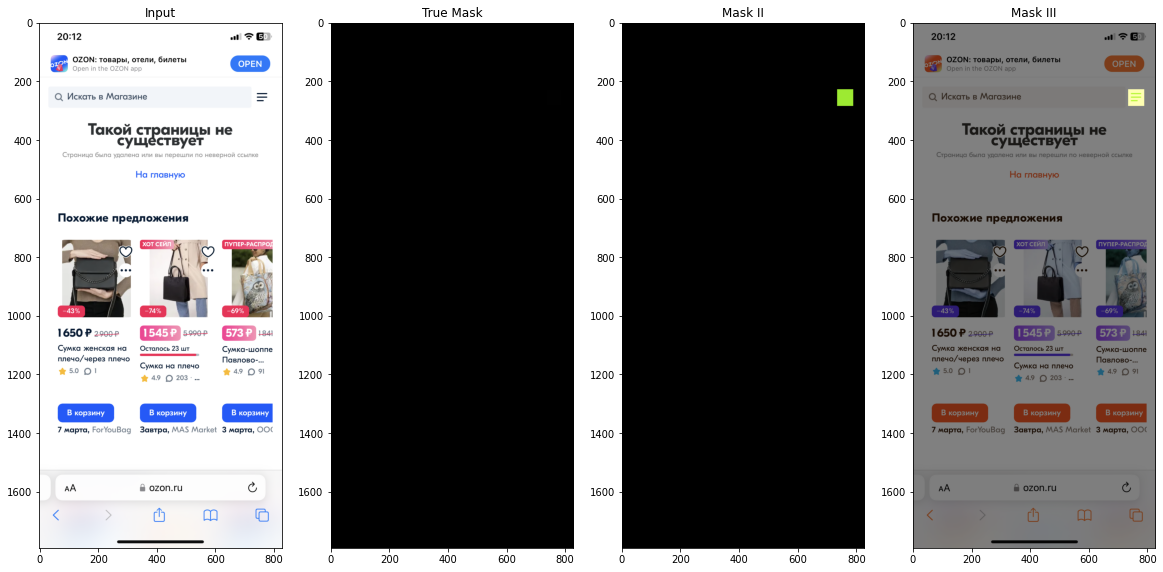

In [8]:
image = cv.imread(images_path[15])
mask = cv.imread(masks_path[15])
print(masks_path[0])
plt.figure(figsize = (20,70))


plt.subplot (1,4,1)
plt.title("Input")
plt.imshow (cv.cvtColor(image,cv.COLOR_BGR2RGB))

plt.subplot(1,4,2)
plt.title("True Mask")
plt.imshow (mask)

plt.subplot (1,4,3)
plt.title("Mask II")
plt.imshow (colors[mask[:,:,2]])

plt.subplot (1,4,4)
plt.title("Mask III")
plt.imshow (cv.addWeighted(image.astype(np.int32), 0.5,colors[mask[:,:,2]].astype(np.int32), 1.,0))
plt.show()




### Функция  аугментации
Данная функция предназначена для исскуственного увеличения размера датасета за счет копирования и последующего преобразования изображений

In [9]:
def augmentate_images(image, masks):   
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    return image, masks

### Unet Model


In [10]:
input_SIZE = (second_d,first_d)
def input_layer():
    return tf.keras.layers.Input(shape= input_SIZE + (3,))
inp_layer = input_layer()
inp_layer

<KerasTensor: shape=(None, 768, 320, 3) dtype=float32 (created by layer 'input_1')>

In [11]:
from keras.models import Sequential, load_model
import tensorflow_addons as tfa
from keras.layers import Conv2D, MaxPool2D,UpSampling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2DTranspose, LeakyReLU, ReLU
from keras.optimizers import Adam as adam
from keras.optimizers import SGD
from keras.metrics import RootMeanSquaredError
from keras import initializers
import math

def downsample_block(filters, size):
    initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)
    
    result =Sequential()

    result.add(Conv2D(filters, size,padding='same',kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
    result.add(ReLU())

    result.add(Conv2D(filters, size, padding='same',kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
    result.add(ReLU())
    
    result.add(MaxPool2D(pool_size = 2, padding='same'))
    result.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
    result.add(ReLU())

    return result


def upsample_block(filters, size, dropout_true=False, dropout=0.05, last_layer=False,bottelneck = False):
    initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

    result = Sequential()

    if bottelneck:
      # result.add(UpSampling2D(size=(2, 2)))
      result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    else:
      result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
            
      result.add(Conv2D(filters, size, padding='same',kernel_initializer=initializer, use_bias=False))
      result.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
      result.add(ReLU())

      if dropout_true:
        result.add(Dropout(dropout))

      result.add(Conv2D(filters, size,padding='same',kernel_initializer=initializer, use_bias=False))
      result.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
      result.add(ReLU())
      
      if dropout_true:
        result.add(Dropout(dropout))

      # if last_layer:
      #       result.add(Conv2D(filters, 1,padding='same',activation = 'ReLU',kernel_initializer=initializer, use_bias=False))
    
    return result


def output_layer(size):
    initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)
    return  Conv2DTranspose(32, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)

def prelast_conv_layer(filters, size):
    initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)
    return  Conv2D(filters, size,padding='same',activation = 'ReLU',kernel_initializer=initializer, use_bias=False)

def last_conv_layer(filters, size):
    initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)
    return  Conv2D(filters, size,padding='same',activation = 'sigmoid',kernel_initializer=initializer, use_bias=False)


In [12]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(32, 5),
    downsample_block(64, 5),
    downsample_block(128, 3),
    downsample_block(256, 3),
    downsample_block(512, 3),
    downsample_block(1024, 3)]

In [13]:
upsample_stack = [
    upsample_block(1024, 3, bottelneck = True),
    upsample_block(512, 3,dropout_true=True, dropout=0.15),
    upsample_block(256, 3,dropout_true=True, dropout=0.15),
    upsample_block(128, 3,dropout_true=True, dropout=0.10),
    upsample_block(64, 3,dropout_true=True, dropout=0.05),
    upsample_block(32, 5,dropout_true=True,last_layer=True, dropout=0.05)]

out_layer = output_layer(3)
last3conv_layer = prelast_conv_layer(32,5)
last1conv_layer = last_conv_layer(num_classes, 1)

In [14]:
x = inp_layer
downsample_skips = []
for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)

In [15]:
downsample_skips  = downsample_skips[:-1]
downsample_skips = reversed(downsample_skips)

In [16]:
upsample_skips = []
for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    upsample_skips.append(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

In [17]:
out_layer = out_layer(x)
out_layer = last3conv_layer(out_layer)
out_layer = last3conv_layer(out_layer)
out_layer = last1conv_layer(out_layer)

In [18]:
unet = tf.keras.Model(inputs=inp_layer, outputs=out_layer)
tf.keras.utils.plot_model(unet, show_shapes=True, dpi=72)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 384, 160, 32  28384       ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 192, 80, 64)  154368      ['sequential[0][0]']             
                                                                                              

In [19]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_one_hot_io_u"]
        if accuracy >= self.point:
            self.model.stop_training = True


In [20]:
from keras import metrics

unet.compile(optimizer='adam',loss='binary_crossentropy', metrics=[metrics.OneHotIoU(num_classes,[i for i in range(0,num_classes)])])

In [21]:
history = unet.fit(X_train,y_train, validation_data=[X_test,  y_test],batch_size=1, epochs=30,callbacks = [StopOnPoint(0.86)])

Epoch 1/30
520/520 [==============================] - 153s 236ms/step - loss: 0.0183 - one_hot_io_u: 0.5318 - val_loss: 0.0043 - val_one_hot_io_u: 0.7190
Epoch 2/30
520/520 [==============================] - 125s 241ms/step - loss: 0.0049 - one_hot_io_u: 0.7367 - val_loss: 0.0082 - val_one_hot_io_u: 0.6466
Epoch 3/30
520/520 [==============================] - 126s 241ms/step - loss: 0.0043 - one_hot_io_u: 0.7570 - val_loss: 0.0025 - val_one_hot_io_u: 0.7838
Epoch 4/30
520/520 [==============================] - 126s 242ms/step - loss: 0.0036 - one_hot_io_u: 0.7821 - val_loss: 0.0028 - val_one_hot_io_u: 0.7632
Epoch 5/30
520/520 [==============================] - 125s 241ms/step - loss: 0.0035 - one_hot_io_u: 0.7853 - val_loss: 0.0023 - val_one_hot_io_u: 0.8180
Epoch 6/30
520/520 [==============================] - 125s 241ms/step - loss: 0.0034 - one_hot_io_u: 0.7925 - val_loss: 0.0027 - val_one_hot_io_u: 0.7874
Epoch 7/30
520/520 [==============================] - 121s 232ms/step - loss

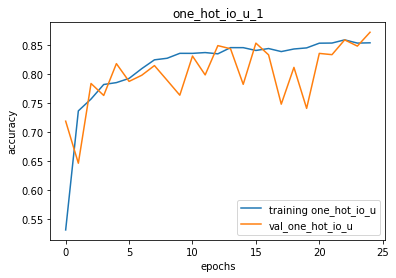

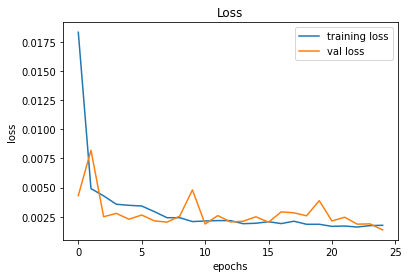

In [22]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['one_hot_io_u'], label='training one_hot_io_u')
plt.plot(history.history['val_one_hot_io_u'], label='val_one_hot_io_u')
plt.title('one_hot_io_u_1')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
def get_ROI(msk_prediction):
  img = cv.cvtColor(msk_prediction.astype(np.uint8),cv.COLOR_BGR2GRAY) #converting to grayscale
  img = img.astype(np.int32)

  coord = cv.findNonZero(img)
  
  #x max, y min
  x_max = max(coord, key=lambda x: (x[0][0]))[0][0]
  y_min = max(coord, key=lambda x: (-x[0][1]))[0][1]
  start_point = [x_max, y_min]

  #x min, y max
  x_min = max(coord, key=lambda x: (-x[0][0]))[0][0]
  y_max = max(coord, key=lambda x: (x[0][1]))[0][1]
  end_point =  [x_min, y_max]
  return start_point, end_point



0.86488676


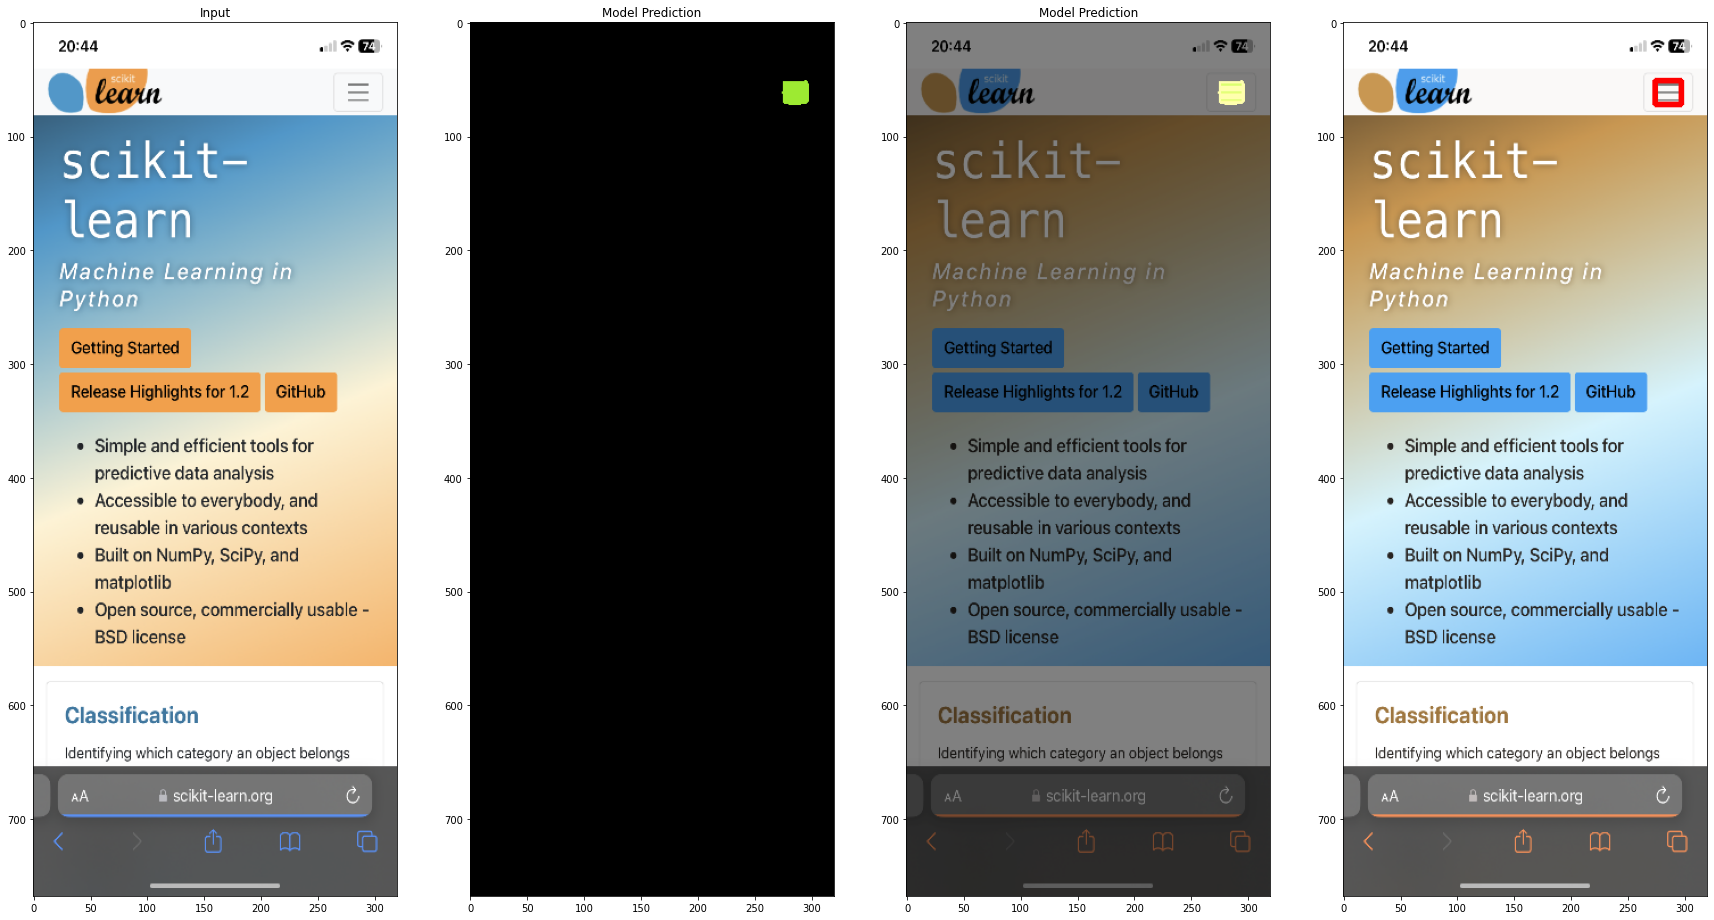

In [24]:
num = 16
x = X_test[num]
y = y_test[num]


pred = unet(np.array([x]))
pred = np.argmax (pred, axis=-1) [0, :,:]

y = np.argmax(y, axis=-1)

iou = tf.keras.metrics.MeanIoU(num_classes=23)
iou.update_state(pred, y)
print(iou.result().numpy())


plt.figure(figsize = (30,30))

plt.subplot (1,4,1)
plt.title("Input")
plt.imshow (cv.cvtColor(x,cv.COLOR_BGR2RGB))

plt.subplot (1,4,2)
plt.title("Model Prediction")
plt.imshow (colors [pred])

plt.subplot (1,4,3)
plt.title("Model Prediction")
plt.imshow (cv.addWeighted(x.astype(np.int32), 0.5,colors[pred].astype(np.int32), 1.,0))

start_point, end_point = get_ROI(colors[pred])
x_clone = x.copy()
ROI_image = cv.rectangle(x_clone, start_point, end_point, (255, 0, 0), 3)
plt.subplot (1,4,4)
plt.imshow(ROI_image)

plt.show()


In [25]:
ALL_PRED = []
for x, y in zip(X_test, y_test):
    
    pred = unet(np.array([x]))
    pred = np.argmax (pred, axis=-1) [0, :,:]

    y = np.argmax(y, axis=-1)

    iou = tf.keras.metrics.MeanIoU(num_classes=23)
    iou.update_state(pred, y)
    print(iou.result().numpy())

    plt.figure(figsize = (20,20))

    plt.subplot (1,4,1)
    plt.title("Input")
    plt.imshow (cv.cvtColor(x,cv.COLOR_BGR2RGB))
  
    plt.subplot (1,4,2)
    plt.title("Model Prediction")
    plt.imshow (colors [pred])
    
    plt.subplot (1,4,3)
    plt.title("Model Prediction")
    plt.imshow (cv.addWeighted(x.astype(np.int32), 0.5,colors[pred].astype(np.int32), 1.,0))

    try:
      start_point, end_point = get_ROI(colors [pred])
      x_clone = x.copy()
      ROI_image = cv.rectangle(x_clone, start_point, end_point, (255, 0, 0), 2)
      plt.subplot (1,4,4)
      plt.title("Model ROI")
      plt.imshow(ROI_image)
    except:
      pass
    plt.show()

 
    ALL_PRED.append(iou.result().numpy())


Output hidden; open in https://colab.research.google.com to view.

In [26]:
def Average(lst):
    return sum(lst) / len(lst)
 
# Driver Code
average = Average(ALL_PRED)

In [27]:
average

0.8667758944630622

In [30]:
84/100

0.84

In [28]:
unet.save('./burger_menu_finder(0.87).h5')